In [1]:
import numpy as np
import matplotlib.pyplot as pp
import math as ma

In [2]:
#from eq6 - predict time or pace for run given set of previous efforts
def predict_pace(dt_pairs,distance): #expects [:,1] to be total time, not tpm.  
    pace_pairs = dt_to_spm(dt_pairs) # (distance,spm)
    eq6 = pacefit_pace(pace_pairs)
    return(eq6(distance))

def get_fit_eq(dt_pairs): #expects [:,1] to be total time, not tpm.  
    pace_pairs = dt_to_spm(dt_pairs) # (distance,spm)
    eq6 = pacefit_pace(pace_pairs)
    return(eq6)

def predict_time(dt_pairs,distance):
    return predict_pace(dt_pairs,distance)*distance

In [3]:
#from eq6 - converts time based coordinate set to pace based, and back

def dt_to_spm(old_set):
    new_set = []
    for old_tuple in old_set:
        if old_tuple[0]!=0:
            new_tuple = (old_tuple[0],old_tuple[1]/old_tuple[0])
            new_set.append(new_tuple)
        else:
            new_tuple = (old_tuple[0],old_tuple[1]/0.00001)
            new_set.append(new_tuple)
    return new_set

def spm_to_dt(old_set):
    new_set = []
    for old_tuple in old_set:
        new_tuple = (old_tuple[0],old_tuple[1]*old_tuple[0])
        new_set.append(new_tuple)
    return new_set

In [4]:
#From eq6 - uses pace curve to determine predicted run time. Methods for time and pace based
def pacefit_times(times):
    paces = dt_to_spm(times)
    paces_np = np.array(paces)
    return pf3(paces_np)

def pacefit_pace(paces):
    paces_np = np.array(paces)
    return pf3(paces_np)

def pf3(distance_pace):
    x = distance_pace[:,0]  #get x from tuples
    y = distance_pace[:,1]  #get y from tuples
    p = np.polyfit(x, y, 3) #get polyfit outcome
    f = np.poly1d(p)        #get function
    return f

In [5]:
#from eq5 - plot run efforts by time or pace

def pacelines(paces):
    for pace in paces:
        pp.plot([0,6],[pace*60,pace*60],lw='2',color = '#aaaaaa')
        
def altgraph(tuples):
    pacelines([3,4,5,6])
    xdata = []
    ydata = []
    for t in tuples:
        xdata.append(t[0])
        ydata.append(t[1]/(t[0]+0.00001))
    print(xdata)
    print(ydata)
    pp.scatter(xdata,ydata)
    pp.show()

def plot_dpr_paces(sets):
    pacelines([3,4,5,6])
    count = 0
    for s in sets:
        count+=1
        xdata = []
        ydata = []
        for ss in s:
            xdata.append(ss[0])
            if ss[0]==0:
                ydata.append(ss[1]/0.00001)
            else:
                ydata.append(ss[1]/ss[0])
            
        pp.scatter(xdata,ydata,marker="o",color = getcolor(count))
        #pp.plot(xdata,ydata,lw='2',marker="o",color = getcolor(count))
    pp.title("Expected pace from distance") 
    pp.show()
    
def plot_tfd_times(sets):
    count = 0
    for s in sets:
        count+=1
        xdata = []
        ydata = []
        for ss in s:
            xdata.append(ss[0])            
            ydata.append(ss[1])
        pp.scatter(xdata,ydata,marker="o",color = getcolor(count))

        #pp.plot(xdata,ydata,lw='2',marker="o",color = getcolor(count))
    pp.title("Plotting time against distance") 

    pp.show()

    
def getcolor(i):
    if i==None:
        return hex6()
    elif i==-1:
        return 'black'
    elif i==1:
        return 'red'
    elif i==2:
        return 'blue'
    elif i==3:
        return 'green'
    elif i==4:
        return 'purple'
    elif i==5:
        return 'orange'
    else:
        return 'gray'

def hex6():    
    col = '#'
    while len(col)<7:
        val = ra.randint(0,15)
        if val<10:
            col+=str(val)
        else:
            col+=chr(87+val)
    return col

def ms(minutes,seconds):
    return (minutes*60)+seconds

def hms(hours,minutes,seconds):
    return (hours*3600)+(minutes*60)+seconds
        

In [6]:
#from eq8 - selects and uses data points that offer fastest pace curve. Simplified and modified here
class curator():
    def __init__(self):
        print("creating data point curator")
        self.activities = []
        
        self.included = []
        self.excluded = []
            
            
    def add_data(self,act):
        self.activities.append(act)
        #if len(self.activities)>=3: 
            #print("skipping auto-evaluate. currently only prompting manually")
            #print(len(self.activities))
            #self.evaluate_all()
            
    def evaluate_all(self):
        if len(self.activities)<3:
            print("Not enough data points. Add more activities")
            return
            
        points = []
        
        for a in self.activities:
            points.append(a.use())
            
        standard = predict_time(points,1)
        print("evaluation standard: "+str(standard))
        
        
        for i in range(len(points)):
            graphable = points[:i]+points[i+1:]
            prediction = predict_time(graphable,1)
            #value = (standard - prediction)/standard this worked but minimizes differences, making comparisons less effective
            value = standard - prediction
            
            self.activities[i].value = value
            print("("+str(self.activities[i].d)+"/"+str(self.activities[i].t)+") has estimated value of "+str(value))
        val_sort(self.activities)
        
        
    def value_plot(self,portion):
        if portion>1 or portion<0:
            print("invalid slice, defaulting to .5")
            portion=0.5
        divider = int(len(self.activities) * portion)
        
        slowlist = self.activities[0:divider-1]
        fastlist = self.activities[divider:]
        
        self.included = fastlist
        self.excluded = slowlist
        
        for i in range(len(slowlist)):
            slowlist[i] = slowlist[i].use()
            
        for i in range(len(fastlist)):
            fastlist[i] = fastlist[i].use()
            
            
        
            
        plot_tfd_times([fastlist,slowlist])
        
        


In [7]:
#from eq8 - represents a single activity along with curation value. Simplified and modified here

class activity():
    def __init__(self,dist,time):
        #self.using = False
        self.value = 1
        
        self.d = dist
        self.t = time
        self.spm = time/dist
        
    def use(self): #return graphable coordinate pair
        return (self.d,self.spm)

In [8]:
#sorts activity array by value
def val_sort(arr):
    s = val_split(arr,0,len(arr)-1)
    val_sort2(arr,s+1,len(arr)-1)
    val_sort2(arr,0,s-1)
    return arr

def val_sort2(arr, _min, _max):
    if _min<_max:
        s = val_split(arr,_min,_max)
        val_sort2(arr,s+1,_max)
        val_sort2(arr,_min,s-1)
    return arr

def val_split(arr, min, max):
    pivot = arr[max]
    #print(arr)
    #pivot = arr[len(arr)-1]
    i = min - 1
    for j in range(min, max):
        if arr[j].value <= pivot.value:
            i+=1
            (arr[i], arr[j]) = (arr[j], arr[i])
    (arr[i + 1], arr[max]) = (arr[max], arr[i + 1])
    return i+1

In [9]:
wr_set = [(0.25, 43),(0.5, 101),(1, 223),(2, 478),(3.1, 750),(4.97, 1264)] # world records 400m to 5000m
jm_set = [(0.25, 54),(0.5, 120),(1, 275),(2, 600),(3.1, 960),(4.97, 1610)] # ya boy
ms_set = [(0.25, 55),(0.5, 121),(1, 272),         (3.1, 925),(4.97, 1560)] # max, naturally

allsets = wr_set + jm_set + ms_set

dup_set = [(0.25, 54),(0.25, 56),(0.5, 120),(0.5, 130),(1, 275),(1, 280),(2, 600),(2, 610),(3.1, 960),(3.2, 960),(4.97, 1610),(4.97, 1620)] # ya boy



c = curator()
for j in dup_set:
    c.add_data(activity(j[0],j[1]))


creating data point curator


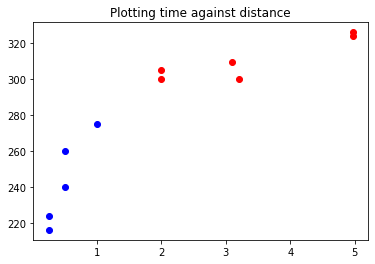

evaluation standard: 303.65302031361944
(0.25/54) has estimated value of -0.3011564551833317
(0.25/56) has estimated value of -0.45092204890818266
(0.5/120) has estimated value of -16.950493494737884
(0.5/130) has estimated value of -11.090553960751322
(1/275) has estimated value of -9.87879836861373
(1/280) has estimated value of -8.154931519588558
(2/600) has estimated value of 20.240609391685894
(2/610) has estimated value of 20.925922701100944
(3.1/960) has estimated value of 4.011177954231243
(3.2/960) has estimated value of 8.671383704109758
(4.97/1610) has estimated value of 0.11298742866915745
(4.97/1620) has estimated value of 0.12170573009029795


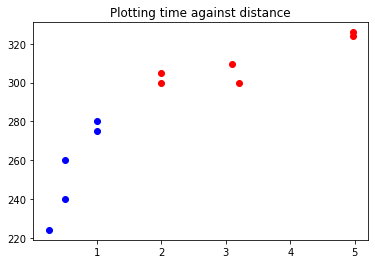

In [10]:
c.value_plot(.5)
c.evaluate_all()
c.value_plot(.5)

In [11]:
c.excluded

[(0.5, 240.0), (0.5, 260.0), (1, 275.0), (1, 280.0), (0.25, 224.0)]

In [12]:
c.included


[(4.97, 323.943661971831),
 (4.97, 325.95573440643864),
 (3.1, 309.6774193548387),
 (3.2, 300.0),
 (2, 300.0),
 (2, 305.0)]

In [13]:
eq = get_fit_eq(dup_set)

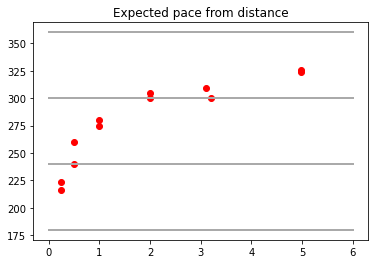

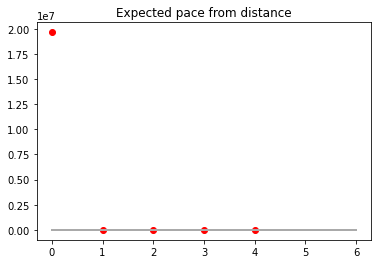

In [14]:
points = []
for i in range (0,5):
    points.append((i,eq(i)))
plot_dpr_paces([dup_set])
plot_dpr_paces([points])

